In [38]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
import tensorflow as tf

print("TensorFlow version: ", tf.__version__)

In [ ]:
train_dir = '/Users/sathvikchowdaryveerapaneni/Desktop/ANIE/DataSet/train'
test_dir = '/Users/sathvikchowdaryveerapaneni/Desktop/ANIE/DataSet/test'




In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

In [ ]:
# Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Create the model
model = Model(inputs=vgg_conv.input, outputs=vgg_conv.output)

# Add new layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
dropout = Dropout(0.5)(class1)
output = Dense(1, activation='sigmoid')(dropout)

# define new model
model = Model(inputs=model.inputs, outputs=output)

# summarize
model.summary()
model_path = 'best_model.h5'

In [ ]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model_path = 'best_model.h5'

# Create the callback
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [ ]:
# Train the model
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples/train_generator.batch_size,
        epochs=12,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples/validation_generator.batch_size,
        verbose=1,
        callbacks=[checkpoint]) 

In [ ]:
# Evaluate the model
scores = model.evaluate_generator(validation_generator)

print("\nAccuracy = ", scores[1])


In [ ]:
# Specify where you want the model to be saved
model.save('First_Model.h5')

Testing images for category: NSFW
1/1 [==============================] - 0s 361ms/step


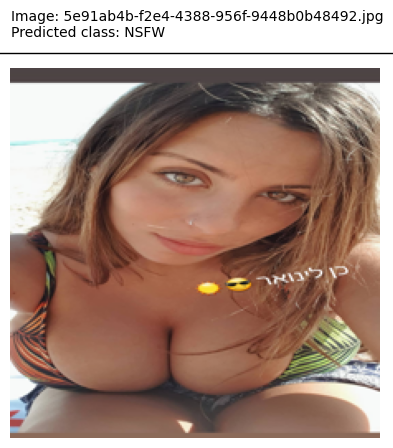

1/1 [==============================] - 0s 22ms/step


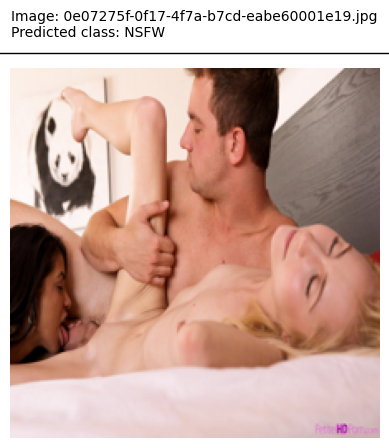

1/1 [==============================] - 0s 19ms/step


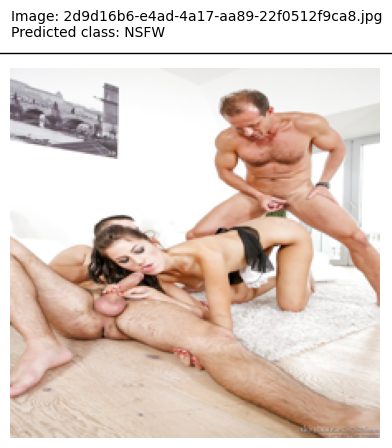

1/1 [==============================] - 0s 18ms/step


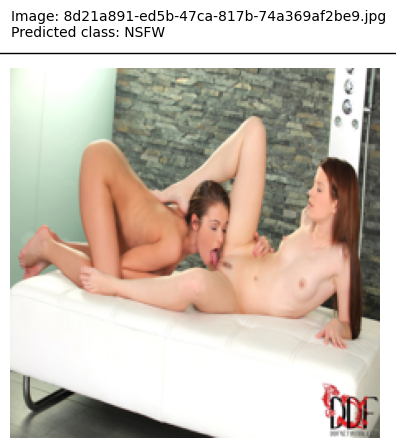

1/1 [==============================] - 0s 18ms/step


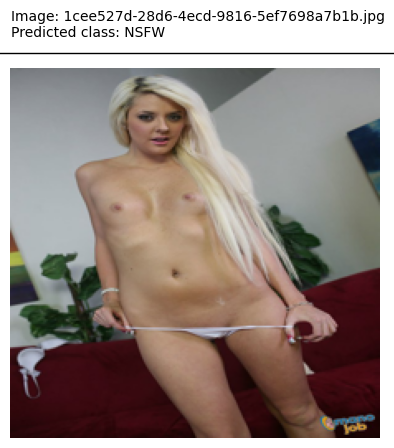

Testing images for category: SFW
1/1 [==============================] - 0s 20ms/step


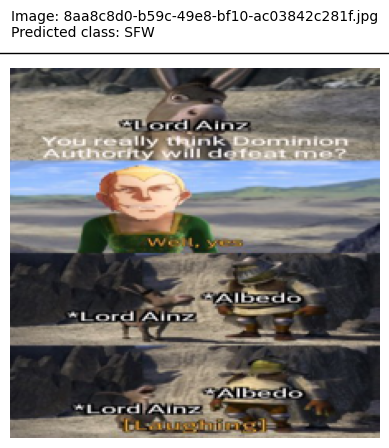

1/1 [==============================] - 0s 19ms/step


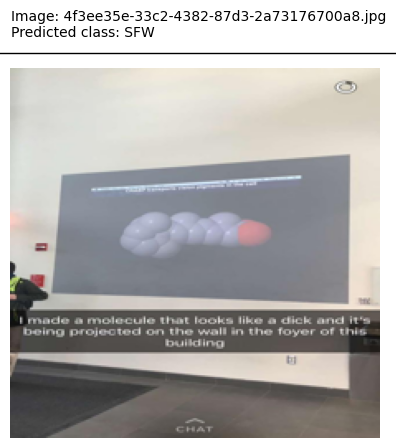

1/1 [==============================] - 0s 18ms/step


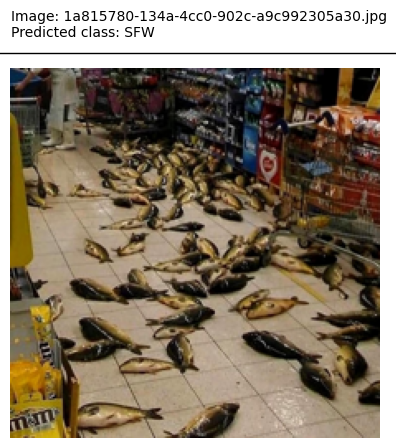

1/1 [==============================] - 0s 18ms/step


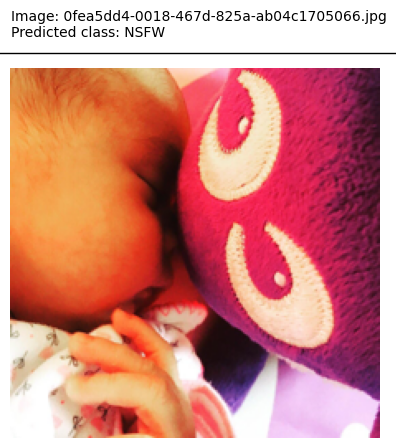

1/1 [==============================] - 0s 22ms/step


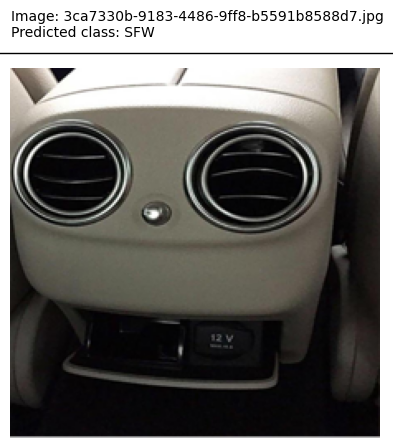

In [42]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import os
import random
from PIL import Image

# Load the model
# model = load_model('path_to_my_model')

# Path to nsfw and sfw test images
nsfw_test_dir = '/Users/sathvikchowdaryveerapaneni/Desktop/ANIE/DataSet/test/nsfw'
sfw_test_dir = '/Users/sathvikchowdaryveerapaneni/Desktop/ANIE/DataSet/test/sfw'

# Sample 5 random images from each category
nsfw_test_images = random.sample(os.listdir(nsfw_test_dir), 5)
sfw_test_images = random.sample(os.listdir(sfw_test_dir), 5)

for category, test_images in zip(["NSFW", "SFW"], [nsfw_test_images, sfw_test_images]):
    print(f"Testing images for category: {category}")
    for img_name in test_images:
        img_path = os.path.join(nsfw_test_dir if category == "NSFW" else sfw_test_dir, img_name)
        
        # Open the image file with PIL and resize
        img = Image.open(img_path).resize((224, 224))  # resize to exactly 224x224
        
        # Convert the image to an array for prediction
        img_array = image.img_to_array(img)
        img_array_expanded = np.expand_dims(img_array, axis=0)
        img_array_expanded /= 255.

        # Predict the class of the image
        predictions = model.predict(img_array_expanded)
        predicted_class = 'NSFW' if predictions[0] < 0.5 else 'SFW'  # change according to your threshold

        # Display the image and its predicted class
        plt.imshow(img)  # img is already a PIL Image object, no need to convert it to an array for display
        plt.axis('off')
        plt.text(0, -20, f"Image: {img_name}\nPredicted class: {predicted_class}", 
                 bbox={'facecolor': 'white', 'pad': 10})  # add text below image
        plt.show()
